Ya sabemos como funciona el univariado_unistep, me da una variable y me da un step de tiempo, o sea, solo predigo 10minxd

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/weather_dataset_PREprocesado.csv')

hacer el split de datos

In [3]:
def train_val_test_split(serie, tr=0.8, ts=0.1, vl=0.1):
    N = len(serie)
    Ntrain = int(N*tr)
    Nval = int(N*vl)
    Ntest = int(N*ts)
    
    train = serie[:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]
    
    print(f'train: {train.shape}')
    print(f'val: {val.shape}')
    print(f'test: {test.shape}')
    
    return train, val, test


In [4]:
# recordar que es UNIVARIADO, por lo que será solo T (degC)
train, val, test = train_val_test_split(df['T (degC)'])

train: (336614,)
val: (42076,)
test: (42078,)


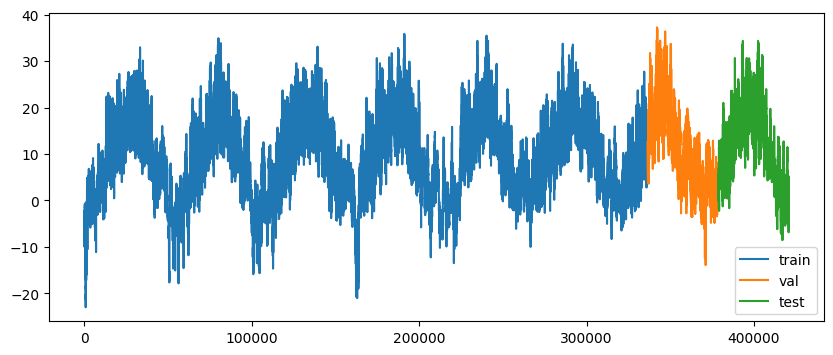

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train, label='train')
ax.plot(val, label='val')
ax.plot(test, label='test')
plt.legend()

Acá lo que hago es crear un dataset supervisado...
- Sacamos las filas y las columnas, cuando es una sola dimensión sale por ejemplo, `(3444,)` y no sale el uno, entonces es necesario ponerlo. Si no es univariado pues no es necesario ponerle el uno, saldría `(3444,2)`.

La parte supervisada es como el split que hicimos arriba.
- El `range(rows - input_length - output_length)` no permite que la iteración se salga de los límites. 
- La `X` va agarrando el input de entrada y avanzando según la i, por ejemplo
```python
    input_length = 3
    array = [1, 2, 3, 4, 5]
    X = []
    # Iteración 1 (i=0):
    X.append([1, 2, 3])
    # Iteración 2 (i=1):
    X.append([2, 3, 4])
    # Iteración 3 (i=2):
    X.append([3, 4, 5])

    # si fuesen más columnas pues seria algo tipo
    array = np.array([[1, 10], [2, 20], [3, 30], [4, 40], [5, 50]])
    # primera itración
    array[0:2, :2]  # Resultado: [[ 1, 10], [ 2, 20]]
    # segunda iteración y así...
    array[1:3, :2]  # Resultado: [[ 2, 20], [ 3, 30]]
```
- La `Y` es lo mismo, empieza desde lo que agarra `X`, hasta lo que agarra `X` más la salida, y escoge la ultima columna que se supone que es el target, luego ahí hace el reshape para que quede de una dimension, tipo `(6,1)` en mi caso, por ejemplo
```python
    # una es temp y la otra humedad
    serie = [[1, 10],
            [2, 20],
            [3, 30],
            [4, 40],
            [5, 50],
            [6, 60],
            [7, 70],
            [8, 80]]

    # Teniendo esto...
    input_length = 3
    output_length = 2

    # La primera iteración llegaria hasta el 3 y coge 4,5, pero 4,5 están en temp, y queremos es humedad, entonces es 40,50.
    array[3:5, -1] = [40, 50]

    # Luego el reshape lo que hace es que cambia de (2,) a (2,1), esto es para que me quede como columna y ya
```

In [6]:
def crear_dataset_supervisado(array, input_length, output_length):    
    X, Y = [], []
    
    # Sacamos filas y columnas
    shape = array.shape
    if len(shape) ==1:
        rows, cols = array.shape[0], 1
        array = array.reshape(rows, cols)
    else:
        rows, cols = array.shape
    
    # Ahora creamos el supervisado, con X y Y
    for i in range(rows - input_length - output_length):
        X.append(array[i:i+input_length, :cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y
        

Esto es un poco confuso, voy a poner en ``input_length`` 144, o sea que el batch va a ser de 144, que son 24 horas, (1440 son 24 horas, dividido en 10, seria 144), y ``output_length`` 6, que es una hora. todo esto es porque tenemos steps de 10min

In [7]:
# como lo tengo de 10min, 144 seria 24 horas
input_length = 144
# lo ideal seria poner 6, que son una hora, pero como es uni-step...
output_length = 1

x_train, y_train = crear_dataset_supervisado(train.values, input_length,output_length)
x_val, y_val = crear_dataset_supervisado(val.values, input_length, output_length)
x_test, y_test = crear_dataset_supervisado(test.values, input_length, output_length)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: (336469, 144, 1), y_train: (336469, 1, 1)
x_val: (41931, 144, 1), y_val: (41931, 1, 1)
x_test: (41933, 144, 1), y_test: (41933, 1, 1)


## Escalamiento

In [ ]:
x_train['x_train'].shape[2]

1

In [ ]:
def escalar_dataset(data_input):
    NFEATS = data_input['x_train'].shape[2]
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]
    
    x_train_s = np.zeros(data_input['x_train'].shape)
    x_val_s = np.zeros(data_input['x_val'].shape)
    x_test_s = np.zeros(data_input['x_test'].shape)
    y_train_s = np.zeros(data_input['y_train'].shape)
    y_val_s = np.zeros(data_input['y_val'].shape)
    y_test_s = np.zeros(data_input['y_test'].shape)
    
    for i in range(NFEATS):
        x_train_s[:, :, i] = scalers[i].fit_transform(data_input['x_train'][:, :, i])
        x_val_s[:, :, i] = scalers[i].transform(data_input['x_val'][:, :, i])
        x_test_s[:, :, i] = scalers[i].transform(data_input['x_test'][:, :, i])
        
    y_train_s[:,:,0] = scalers[-1].fit_transform(data_input['y_train'][:,:,0])
    y_val_s[:,:,0] = scalers[-1].transform(data_input['y_val'][:, :, 0])
    y_test_s[:,:,0] = scalers[-1].transform(data_input['y_test'][:, :, 0])
    
    data_scaled = {
        'x_train_s': x_train_s,
        'x_val_s': x_val_s,
        'x_test_s': x_test_s,
        'y_train_s': y_train_s,
        'y_val_s': y_val_s,
        'y_test_s': y_test_s
    }
    
    return data_scaled, scalers[0]

In [15]:
data_in = {
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'x_val': x_val,
    'y_val': y_val
}

data_s, scaler = escalar_dataset(data_in)

x_train_s, y_train_s = data_s['x_train_s'], data_s['y_train_s']
x_val_s, y_val_s = data_s['x_val_s'], data_s['y_val_s']
x_test_s, y_test_s = data_s['x_test_s'], data_s['y_test_s']

print(x_train.min(), x_train.max())
print(x_train_s.min(), x_train_s.max())

-23.01 35.86
-1.0 0.9999999999999999
